In [28]:
# Cell 1: Imports and specifications
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# --- HARD-CODED USER PARAMETERS ---
# (if BP or RB: fp and fsb should be np.array's of size 2 with frequencies 
# in increasing order)
fs       = 20000                # Sampling frequency (Hz)
T = 1 / fs
fp       =  2500                # Passband edge (Hz)
fsb      =  4000                # Stopband edge (Hz)
Ap       =     1                # Passband ripple (dB)
As       =    40                # Stopband attenuation (dB)
approx   = 'ellip'              # Approximation: 'butter','cheby1','cheby2','ellip'
fshape   = 'lowpass'            # Filter shape: 'lowpass','highpass','bandpass','bandstop'

In [29]:
# Cell 2: Pre-warp digital → analog
# 1) Digital angular frequency rad/s:
omega_p = 2*np.pi * fp 
omega_s = 2*np.pi * fsb
# 2) Pre-warp into analog rad/s:
Omega_p = (2/T) * np.tan(omega_p*T/2)
Omega_s = (2/T) * np.tan(omega_s*T/2)

print("Digital ω_p (rad/s):", omega_p)
print("Digital ω_s (rad/s):", omega_s)
print()
print("Pre-warped analog Ω_p (rad/s):", Omega_p)
print("Pre-warped analog Ω_s (rad/s):", Omega_s)

Digital ω_p (rad/s): 15707.963267948966
Digital ω_s (rad/s): 25132.741228718343

Pre-warped analog Ω_p (rad/s): 16568.542494923804
Pre-warped analog Ω_s (rad/s): 29061.701120214435


In [30]:
# Cell 3: Compute analog prototype order, analog TF
if   approx == 'butter':
    N, Wn = signal.buttord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.butter(N, Wn, btype=fshape, analog=True)
elif approx == 'cheby1':
    N, Wn = signal.cheb1ord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.cheby1(N, Ap, Wn, btype=fshape, analog=True)
elif approx == 'cheby2':
    N, Wn = signal.cheb2ord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.cheby2(N, As, Wn, btype=fshape, analog=True)
elif approx == 'ellip':
    N, Wn = signal.ellipord(Omega_p, Omega_s, Ap, As, analog=True)
    b_a, a_a = signal.ellip(N, Ap, As, Wn, btype=fshape, analog=True)
else:
    raise ValueError("Unsupported approximation method")
print(f"Analog {approx} {fshape} prototype: order={N}, Wn={Wn} rad/s")

Analog ellip lowpass prototype: order=4, Wn=16568.542494923804 rad/s


In [31]:
# Cell 4: Bilinear transform → digital filter (signal.bilinear doesn't pre warp)
b_z, a_z = signal.bilinear(b_a, a_a, fs)

print("H(z) numerator  b_z =", b_z)
print()
print("H(z) denominator a_z =", a_z)

H(z) numerator  b_z = [ 0.02635924 -0.00121753  0.03806096 -0.00121753  0.02635924]

H(z) denominator a_z = [ 1.         -2.69229242  3.23010102 -1.91887044  0.48018587]


In [32]:
# Cell 4bis: Compute analog unpre-warped TF just for comparison
if   approx == 'butter':
    N, Wn = signal.buttord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.butter(N, Wn, btype=fshape, analog=True)
elif approx == 'cheby1':
    N, Wn = signal.cheb1ord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.cheby1(N, Ap, Wn, btype=fshape, analog=True)
elif approx == 'cheby2':
    N, Wn = signal.cheb2ord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.cheby2(N, As, Wn, btype=fshape, analog=True)
elif approx == 'ellip':
    N, Wn = signal.ellipord(omega_p, omega_s, Ap, As, analog=True)
    b_a2, a_a2 = signal.ellip(N, Ap, As, Wn, btype=fshape, analog=True)
else:
    raise ValueError("Unsupported approximation method")

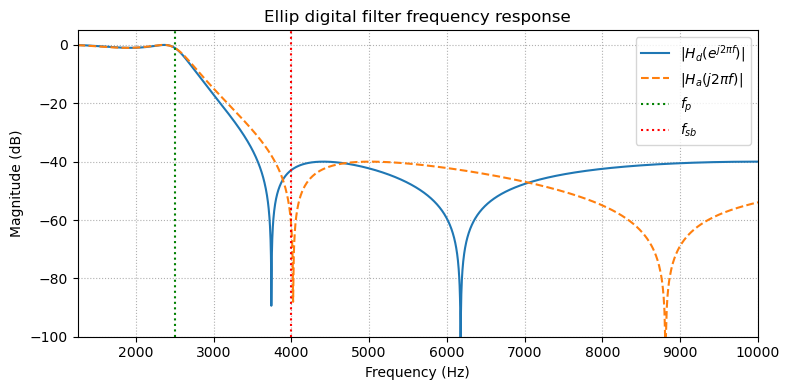

In [33]:
# Cell 5: Plot frequency response
# Digital response 
w_z, h_z = signal.freqz(b_z, a_z, worN=4096, fs=fs)
f_z = w_z

# Analog response (unpre-warped)
w_s, h_s = signal.freqs(b_a2, a_a2, worN=4096)  
f_s = w_s/(2*np.pi)

# Convert to dB
Hz_dB = 20*np.log10(np.abs(h_z) + 1e-12)
Hs_dB = 20*np.log10(np.abs(h_s) + 1e-12)

# Plot both
plt.figure(figsize=(8,4))
plt.plot(f_z, Hz_dB, label=r'$|H_d(e^{j2\pi f})|$')
plt.plot(f_s, Hs_dB, label=r'$|H_a(j2\pi f)|$', linestyle='--')
# give the lines labels so they appear in the legend
    # estas dos proximas lineas hay que comentarlas cunado se usa BP o BR
plt.axvline(fp,  color='green', linestyle=':', label=r'$f_p$')
plt.axvline(fsb, color='red',   linestyle=':', label=r'$f_{sb}$')
plt.title(f"{approx.capitalize()} digital filter frequency response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.ylim(-100, 5)
# tighten the x–range around your region of interest
    # y en la prox linea hay que harcodear donde dice fp/2 cuando se usa BP o BR
plt.xlim(fp/2, fs/2)  
plt.legend(loc='best')
plt.grid(which='both', linestyle=':')
plt.tight_layout()
plt.show()
